In [178]:
from typing import Sequence
import geopandas as gpd
from shapely.geometry import Polygon,LineString
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = ['SimHei']

In [179]:
def get_cross_pt(xc,yc,y):
    # 计算交点前后点序号
    coords = list(zip(xc, yc))
    segment = []
    for i, val in enumerate(coords):
        xi, yi = val
        if yi < y:
            segment.append(i)

    if segment[0]==0:
        xy1_left=coords[segment[0]]
    else:
        xy1_left = coords[segment[0]-1]
    xy1_right = coords[segment[0]]

    xy2_left = coords[segment[-1]]
    if segment[-1]==len(yc)-1:
        xy2_right = coords[segment[-1]]
    else:
        xy2_right = coords[segment[-1]+1]

    # 左岸交点x值
    x1_left, y1_left = xy1_left
    x1_right, y1_right = xy1_right

    if y1_left==y1_right:
        x0_1=x1_left
    else:
        x0_1 = x1_left - (x1_left - x1_right) * (y1_left - y) / (y1_left - y1_right)
    
    # 右岸交点x值
    x2_left, y2_left = xy2_left
    x2_right, y2_right = xy2_right

    if y2_left==y2_right:
        x0_2=x2_left
    else:
        x0_2 = x2_left - (x2_left - x2_right) * (y2_left - y) / (y2_left - y2_right)
    return x0_1,x0_2,segment

In [180]:
x = [0, 1, 2, 3, 4, 5, 6, 7, 8]
y = [10, 3, 3, 0, 0, 0, 1, 1, 2]
q = 20
s = 0.001  # 河床水力坡度

#---参数---#
nc = 0.03  # 主槽糙率系数
ntl = 0.1  # 左滩区糙率
ntr = 0.06  # 右滩区糙率

tlidx = 2  # 左岸滩分界点序号
tridx = 6  # 右岸滩分界点序号
dcidx = 4  # 主槽最低点序号


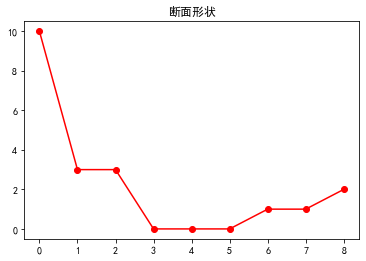

In [181]:
plt.plot(x, y, 'ro-')
plt.title("断面形状")
plt.show()


In [182]:
#---待求参数---#
yn = 0  # 待求水深
velocity = 0  # 待求流速


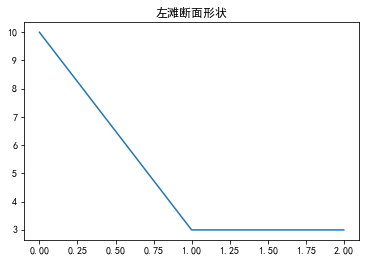

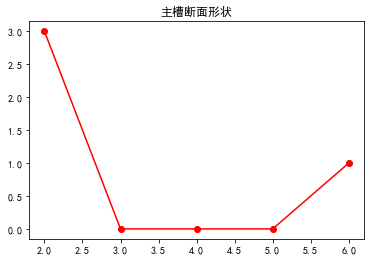

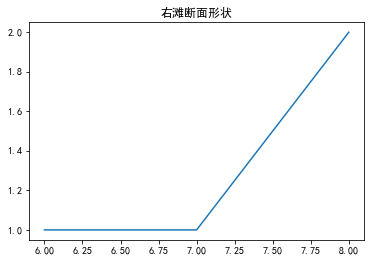

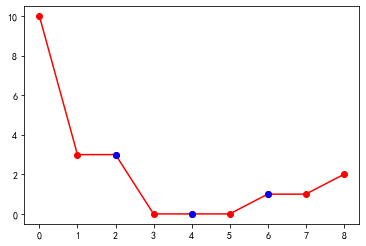

In [183]:
#---左岸滩区坐标---#
xtl = x[:tlidx+1]
ytl = y[:tlidx+1]

plt.plot(xtl, ytl)
plt.title("左滩断面形状")
plt.show()

#---主槽坐标---#
xc = x[tlidx:tridx+1]
yc = y[tlidx:tridx+1]
xcl = x[tlidx:dcidx+1]
ycl = y[tlidx:dcidx+1]
xcr = x[dcidx:tridx+1]
ycr = y[dcidx:tridx+1]
dc = y[dcidx]

plt.plot(xc, yc, 'ro-')
plt.title("主槽断面形状")
plt.show()

#---右岸滩区坐标---#
xtr = x[tridx:]
ytr = y[tridx:]

plt.plot(xtr, ytr)
plt.title("右滩断面形状")
plt.show()

plt.plot(x, y, 'ro-')
plt.plot(x[tlidx], y[tlidx], 'bo-')
plt.plot(x[tridx], y[tridx], 'bo-')
plt.plot(x[dcidx], y[dcidx], 'bo-')


In [184]:
# 左滩湿周点集
xl_tmp = []
yl_tmp = []
# 右滩湿周点集
xr_tmp = []
yr_tmp = []
# 主槽湿周点集
x_tmp = []
y_tmp = []


In [185]:
#---迭代水深，直至计算的流量大于等于给定流量---#
#---忽略滩区低于主河槽的情况---#
while(True):
    yn = yn+0.01
    d = dc+yn  # 水深换算为水位
    #---计算过水面积---#
    # 水深低于两岸堤防：只计算主槽过水面积
    if d <= yc[0] and d <= yc[-1]:
        # 插值生成该水深下两岸坐标
        xl0, xr0, segment = get_cross_pt(xc, yc, d)
        # 拼接成过水断面点集合
        x_tmp = np.append(
            np.append([xl0], xc[segment[0]:segment[-1]+1]), [xr0])
        y_tmp = np.append(
            np.append([d], yc[segment[0]:segment[-1]+1]), [d])

        polygon_geom = Polygon(zip(x_tmp, y_tmp))
        polyline_geom = LineString(zip(x_tmp, y_tmp))
        # polygon = gpd.GeoDataFrame(index=[0], geometry=[polygon_geom])
        area = polygon_geom.area
        p = polyline_geom.length

        qc = 1/nc * area * (area/p)**(2/3) * s**0.5
        if qc.real >= q:
            velocity = q/area
            break
    # 水深高于左岸堤防小于右岸堤防：过水面积=主槽过水面积+左岸滩区过水面积，主槽左岸假定为竖直
    elif d > yc[0] and d <= yc[-1]:
        # 计算主槽部分
        # 插值生成该水深下两岸坐标
        xl0, xr0, segment = get_cross_pt(xc, yc, d)
        x_tmp = np.append(np.append(xl0, xc[:segment[-1]+1]), xr0)
        y_tmp = np.append(np.append([d], yc[:segment[-1]+1]), [d])
        polygon_geom = Polygon(zip(x_tmp, y_tmp))
        polyline_geom = LineString(zip(x_tmp, y_tmp))
        area_c = polygon_geom.area
        p_c = polyline_geom.length
        qc = 1/nc * area_c * (area_c/p_c)**(2/3) * s ** 0.5

        # 计算左岸滩区部分,右侧衔接主槽竖壁
        if len(ytl) > 1:
            # 插值生成该水深下两岸坐标
            xl0, xr0, segment = get_cross_pt(xtl, ytl, d)
            # 拼接成过水断面点集合
            xl_tmp = np.append(
                np.append([xl0], xtl[segment[0]:segment[-1]+1]), [xr0])
            yl_tmp = np.append(
                np.append([d], ytl[segment[0]:segment[-1]+1]), [d])
            polygon_geom = Polygon(zip(xl_tmp, yl_tmp))
            polyline_geom = LineString(zip(xl_tmp, yl_tmp))
            area_tl = polygon_geom.area
            p_tl = polyline_geom.length
            qtl = 1/ntl * area_tl * (area_tl/p_tl) ** (2/3) * s ** 0.5

        if (qtl+qc).real >= q:
            area = (area_c+area_tl)
            p = p_c+p_tl
            velocity = q/area
            break
    # 水深高于右岸堤防小于左岸堤防：过水面积=主槽过水面积+右岸滩区过水面积，主槽右岸假定为竖直
    elif d <= yc[0] and d > yc[-1]:
        # 计算主槽部分
        # 插值生成该水深下两岸坐标
        xl0, xr0, segment = get_cross_pt(xc, yc, d)
        x_tmp = np.append(np.append(xl0, xc[segment[0]:]), xr0)
        y_tmp = np.append(np.append([d], yc[segment[0]:]), [d])
        polygon_geom = Polygon(zip(x_tmp, y_tmp))
        polyline_geom = LineString(zip(x_tmp, y_tmp))
        area_c = polygon_geom.area
        p_c = polyline_geom.length
        qc = 1/nc * area_c * (area_c/p_c) ** (2/3) * s ** 0.5

        # 计算右岸滩区部分,左侧衔接主槽竖壁
        if len(ytr) > 1:
            # 插值生成该水深下两岸坐标
            xl0, xr0, segment = get_cross_pt(xtr, ytr, d)
            # 拼接成过水断面点集合
            xr_tmp = np.append(
                np.append([xl0], xtr[segment[0]:segment[-1]+1]), [xr0])
            yr_tmp = np.append(
                np.append([d], ytr[segment[0]:segment[-1]+1]), [d])
            polygon_geom = Polygon(zip(xr_tmp, yr_tmp))
            polyline_geom = LineString(zip(xr_tmp, yr_tmp))
            area_tr = polygon_geom.area
            p_tr = polyline_geom.length
            qtr = 1/ntr * area_tr * area_tr/p_tr ** (2/3) * s ** 0.5

        if (qtr+qc).real >= q:
            area = (area_c+area_tr)
            p = p_c+p_tr
            velocity = q/area
            break
    # 水深高于左右岸堤防：过水面积=主槽过水面积+两岸滩区过水面积
    else:
        # 计算左岸滩区部分,右侧衔接主槽竖壁
        if len(ytl) > 1:
            # 插值生成该水深下两岸坐标
            xl0, xr0, segment = get_cross_pt(xtl, ytl, d)
            # 拼接成过水断面点集合
            xl_tmp = np.append(
                np.append([xl0], xtl[segment[0]:segment[-1]+1]), [xr0])
            yl_tmp = np.append(
                np.append([d], ytl[segment[0]:segment[-1]+1]), [d])
            polygon_geom = Polygon(zip(xl_tmp, yl_tmp))
            polyline_geom = LineString(zip(xl_tmp, yl_tmp))
            area_tl = polygon_geom.area
            p_tl = polyline_geom.length
            qtl = 1/ntl * area_tl * (area_tl/p_tl) ** (2/3) * s ** 0.5

        # 计算右岸滩区部分,左侧衔接主槽竖壁
        if len(ytr) > 1:
            # 插值生成该水深下两岸坐标
            xl0, xr0, segment = get_cross_pt(xtr, ytr, d)
            # 拼接成过水断面点集合
            xr_tmp = np.append(
                np.append([xl0], xtr[segment[0]:segment[-1]+1]), [xr0])
            yr_tmp = np.append(
                np.append([d], ytr[segment[0]:segment[-1]+1]), [d])
            polygon_geom = Polygon(zip(xr_tmp, yr_tmp))
            polyline_geom = LineString(zip(xr_tmp, yr_tmp))
            area_tr = polygon_geom.area
            p_tr = polyline_geom.length
            qtr = 1/ntr * area_tr * (area_tr/p_tr) ** (2/3) * s ** 0.5

        # 计算主槽部分
        x_tmp = np.append(np.append(xc[0], xc), xc[-1])
        y_tmp = np.append(np.append([d], yc), [d])
        polygon_geom = Polygon(zip(x_tmp, y_tmp))
        polyline_geom = LineString(zip(x_tmp, y_tmp))
        area_c = polygon_geom.area
        p_c = polyline_geom.length
        qc = 1/nc * area_c * (area_c/p_c) ** (2/3) * s ** 0.5
        # plt.plot(x_tmp,y_tmp,'bo-')

        if (qtl+qc+qtr).real >= q:
            area = (area_c+area_tl+area_tr)
            p = p_c+p_tl+p_tr
            velocity = q/area
            break


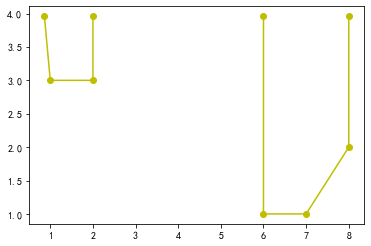

[0, 1, 2, 3, 4, 5, 6, 7, 8]
[10, 3, 3, 0, 0, 0, 1, 1, 2]
[2 2 3 4 5 6 6]
[3.96 3.   0.   0.   0.   1.   3.96]
过水面积：20.285828571428283
湿周：20.76045122768445
流速：0.9859099385355715
水深：3.9599999999999596


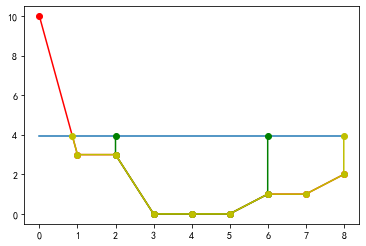

In [186]:
plt.plot(xl_tmp, yl_tmp, 'yo-')
plt.plot(xr_tmp, yr_tmp, 'yo-')
plt.show()

print(x)
print(y)
print(x_tmp)
print(y_tmp)
print('过水面积：'+str(area)+'\n湿周：'+str(p) +
      '\n流速：'+str(velocity)+'\n水深：'+str(yn))
plt.plot(x, y, 'ro-')
plt.plot([x[0], x[-1]], [yn, yn])
plt.plot(x_tmp, y_tmp, 'go-')

xl0,xr0,segment = get_cross_pt(x,y,d)
x_tmp = np.append(np.append(xl0,x[segment[0]:segment[-1]+1]),xr0)
y_tmp = np.append(np.append([d],y[segment[0]:segment[-1]+1]),[d])
plt.plot(x_tmp,y_tmp,'yo-')
plt.show()
